In [ ]:
import mysql.connector
import os
from dotenv import load_dotenv
import time
import threading

In [ ]:
load_dotenv()

Database Setup

In [ ]:
def connection():
    try:
        mydb = mysql.connector.connect(
            user=os.getenv('DB_USER'),
            password=os.getenv('DB_PASSWORD'),
            host=os.getenv('DB_HOST'),
            database=os.getenv('DB_BASE')
        )
        cursor = mydb.cursor()
        return mydb, cursor
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None, None

Inserting Dummy Data

In [ ]:
def setup_data():
    mydb, cursor = connection()
    if not mydb or not cursor:
        print("Database connection failed.")
        return

    customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97'

    try:
        # Delete existing row if it exists
        cursor.execute("DELETE FROM customers WHERE customer_id = %s", (customer_id,))

        # Insert new row
        cursor.execute("""
            INSERT INTO customers (
                customer_id,
                customer_unique_id,
                customer_zip_code_prefix,
                customer_city,
                customer_state
            )
            VALUES (%s, %s, %s, %s, %s)
        """, (
            customer_id,
            'd6ce5d5d1bba4a2fa3b8c6f1fefdc4f5',
            12240,
            'sao paulo',
            'SP'
        ))

        mydb.commit()
        # print("New insert successful.")

    except mysql.connector.Error as err:
        print(f"Error during insertion: {err}")
        mydb.rollback()

    finally:
        cursor.close()
        mydb.close()


Group operations using START TRANSACTION, COMMIT, and ROLLBACK

In [ ]:
def transaction_commit_and_rollback():
    mydb, cursor = connection()
    if not mydb or not cursor:
        print("Database connection failed.")
        return

    print("\n-- COMMIT Example --")
    cursor.execute("START TRANSACTION")
    cursor.execute("UPDATE customers SET customer_city = 'CommittedCity' WHERE customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97'")
    mydb.commit()
    print("Committed update.")

    print("\n-- ROLLBACK Example --")
    cursor.execute("START TRANSACTION")
    cursor.execute("UPDATE customers SET customer_city = 'RolledBackCity' WHERE customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97'")
    mydb.rollback()
    print("Rolled back update.")

    cursor.execute("SELECT * FROM customers WHERE customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97'")
    print("Current customer_city:", cursor.fetchone()[0])

    cursor.close()
    mydb.close()

- The first transaction updates the city and commits it.

- The second transaction changes it but rolls back, so the database retains the previous committed state.

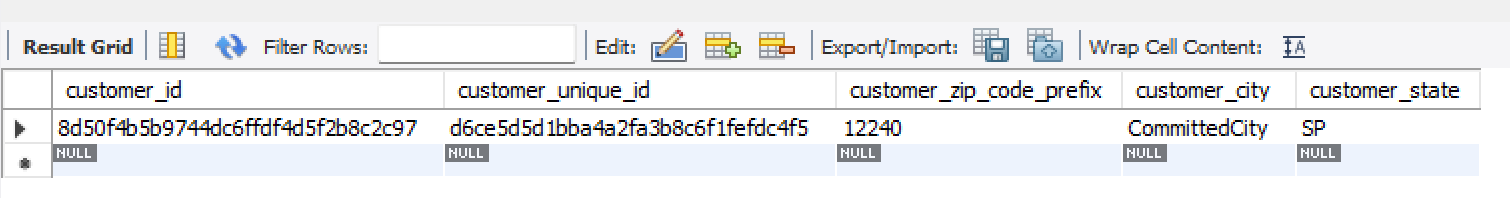

Simulate concurrent access scenarios (e.g., two users attempting conflicting operations).

In [ ]:
def user_update(name, delay, new_city):
    mydb, cursor = connection()
    if not mydb or not cursor:
        print("Database connection failed.")
        return
    cursor.execute("SET SESSION TRANSACTION ISOLATION LEVEL SERIALIZABLE")
    cursor.execute("START TRANSACTION")
    print(f"{name} started and waiting {delay}s...")
    time.sleep(delay)
    cursor.execute(f"UPDATE customers SET customer_city = '{new_city}' WHERE customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97'")
    mydb.commit()
    print(f"{name} committed update to '{new_city}'")
    cursor.close()
    mydb.close()

In [ ]:
def simulate_concurrent_updates():
    print("\n-- Concurrent Transactions Simulation --")
    t1 = threading.Thread(target=user_update, args=("User1", 2, "CityA"))
    t2 = threading.Thread(target=user_update, args=("User2", 1, "CityB"))

    t1.start()
    t2.start()
    t1.join()
    t2.join()

    mydb, cursor = connection()
    if not mydb or not cursor:
        print("Database connection failed.")
        return
    cursor.execute("SELECT customer_city FROM customers WHERE customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97'")
    final_city = cursor.fetchone()[0]
    print("Final city after concurrent updates:", final_city)
    cursor.close()
    mydb.close()

Two users (User1 and User2) attempt to update the same customer's city concurrently. Each operates in its own transaction with a delay, simulating real-world user lag. Both transactions use the SERIALIZABLE isolation level and commit changes independently.

- User2 updates and commits first to set the city as "CityB".

- User1, delayed, then commits later to set it as "CityA".

- Final value in the database becomes "CityA" because the last commit wins.

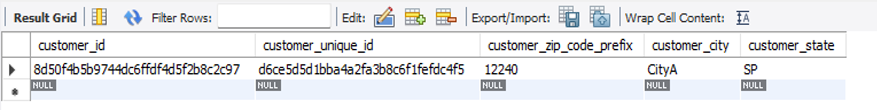

Observe behavior under different isolation levels (e.g., READ COMMITTED, REPEATABLE
READ, SERIALIZABLE)

In [ ]:
def read_under_isolation_level(level):
    mydb, cursor = connection()
    if not mydb or not cursor:
        print("Database connection failed.")
        return
    cursor = mydb.cursor()
    cursor.execute(f"SET SESSION TRANSACTION ISOLATION LEVEL {level}")
    cursor.execute("START TRANSACTION")
    cursor.execute("SELECT customer_city FROM customers WHERE customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97'")
    city1 = cursor.fetchone()[0]
    print(f"[{level}] Read before external change: {city1}")
    time.sleep(4)
    cursor.execute("SELECT customer_city FROM customers WHERE customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97'")
    city2 = cursor.fetchone()[0]
    print(f"[{level}] Read after 4 sec (re-read): {city2}")
    cursor.close()
    mydb.close()

In [ ]:
def external_update():
    time.sleep(2)
    mydb, cursor = connection()
    if not mydb or not cursor:
        print("Database connection failed.")
        return
    cursor = mydb.cursor()
    cursor.execute("UPDATE customers SET customer_city = 'ExternallyChanged' WHERE customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97'")
    mydb.commit()
    cursor.close()
    mydb.close()


In [ ]:
def demonstrate_isolation_levels():
    print("\n-- Isolation Level Example--")
    for level in ['READ COMMITTED', 'REPEATABLE READ', 'SERIALIZABLE']:
        setup_data()
        t1 = threading.Thread(target=read_under_isolation_level, args=(level,))
        t2 = threading.Thread(target=external_update)
        t1.start()
        t2.start()
        t1.join()
        t2.join()


How different SQL isolation levels affected data consistency during concurrent transactions using a shared customers  table:


Scenario

- User A (Thread 1) starts a transaction, reads the customer's city, waits 4 seconds, and re-reads the city.
- User B (Thread 2) waits 2 seconds, updates the same customer's city to 'ExternallyChanged' , and commits.
- This simulates a concurrent update while the first transaction is in progress.



Setup
- Target Row: customer_id = '8d50f4b5b9744dc6ffdf4d5f2b8c2c97' 
- Initial city: 'sao paulo' 
- External change: 'ExternallyChanged' 



Observed Results

| Isolation Level     | First Read    | Second Read         | Behavior                       |
|---------------------|---------------|----------------------|--------------------------------|
| READ COMMITTED  | sao paulo     | ExternallyChanged    | Non-repeatable read        |
| REPEATABLE READ | sao paulo     | sao paulo            | Consistent snapshot        |
| SERIALIZABLE    | sao paulo     | sao paulo            | Strictest isolation        |



Conclusion

- READ COMMITTED : Allows seeing committed changes mid-transaction.
- REPEATABLE READ : Ensures the same value is read every time.
- SERIALIZABLE : Blocks conflicting writes and offers the highest consistency.

Proper transaction isolation helps avoid anomalies like dirty reads, non-repeatable reads, and lost updates in concurrent environments.


In [ ]:
if __name__ == "__main__":
    setup_data()
    transaction_commit_and_rollback()
    simulate_concurrent_updates()
    demonstrate_isolation_levels()